# Load packages

In [1]:
# Ignore warnings
import warnings

def warn(*args, **kwargs):
    pass

warnings.warn = warn

In [2]:
import os
import time
import numpy as np
import pandas as pd
import re

import keras
from keras import *
from keras import layers
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from keras.models import Model
from keras.preprocessing import *
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import pickle

import seaborn as sns
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [3]:
#for reproducible results
from numpy.random import seed
seed(302)
from tensorflow import set_random_seed
set_random_seed(302)

# Load and explore data

In [4]:
sms_df=pd.read_csv('SMSSpamCollection',sep='\t',header=None)

In [5]:
sms_df.head()

,0,1
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
sms_df.tail()

,0,1
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...
5571,ham,Rofl. Its true to its name


In [7]:
# rename variables
sms_df=sms_df.rename(columns={0: 'Labels', 1: 'Text'})

# create binary where 1 = spam and 0 = ham
sms_df['Labels_Binary'] = 0
sms_df.loc[sms_df['Labels']=='spam', 'Labels_Binary'] = 1

In [8]:
texts = sms_df['Text']
labels = sms_df['Labels_Binary']

Partition data into train, valid, test

In [9]:
#Create train/test sample
other_texts, test_texts, other_labels, test_labels  = train_test_split(texts, labels, test_size=0.1, random_state=302)
#Create validation sample
train_texts, valid_texts, train_labels, valid_labels  = train_test_split(other_texts, other_labels, test_size=0.2, random_state=302)

Evaluate ham/spam breakdown

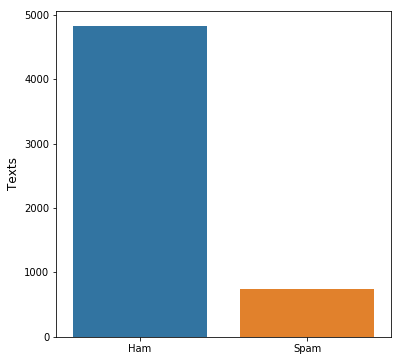

In [10]:
cases_count = labels.value_counts(dropna=False)
        
# Plot  results 
plt.figure(figsize=(6,6))
sns.barplot(x=cases_count.index, y=cases_count.values)
plt.ylabel('Texts', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Ham', 'Spam'])

plt.show()

# Train model

In [11]:
# Define vocabulary size (you can tune this parameter and evaluate model performance)
VOCABULARY_SIZE = 5000

In [12]:
# Create input feature arrays
tokenizer = Tokenizer(num_words=VOCABULARY_SIZE)
tokenizer.fit_on_texts(train_texts)

# Convert words into word ids
meanLength = np.mean([len(item.split(" ")) for item in train_texts])
MAX_SENTENCE_LENGTH = int(meanLength + 5) # we let a text go 10 words longer than the mean text length.

# Convert train, validation, and test text into lists with word ids
trainFeatures = tokenizer.texts_to_sequences(train_texts)
trainFeatures = pad_sequences(trainFeatures, MAX_SENTENCE_LENGTH, padding='post')
trainLabels = train_labels.values

validFeatures = tokenizer.texts_to_sequences(valid_texts)
validFeatures = pad_sequences(validFeatures, MAX_SENTENCE_LENGTH, padding='post')
validLabels = valid_labels.values

testFeatures = tokenizer.texts_to_sequences(test_texts)
testFeatures = pad_sequences(testFeatures, MAX_SENTENCE_LENGTH, padding='post')
testLabels = test_labels.values

In [13]:
# we will use this hardcoded sentence length in the prep for the flask app
MAX_SENTENCE_LENGTH

20

In [14]:
# Define filter and kernel size for CNN (can adjust in tuning model)
FILTERS_SIZE = 16
KERNEL_SIZE = 5

# Define embeddings dimensions (columns in matrix fed into CNN and nodes in hidden layer of built-in keras function)
EMBEDDINGS_DIM = 10

# Hyperparameters for model tuning
LEARNING_RATE = 0.001
BATCH_SIZE = 32
EPOCHS = 7

In [15]:
# Word CNN
model = Sequential()

# We use built-in keras funtion to generate embeddings. Another option is pre-trained embeddings with Word2vec or GloVe.
model.add(Embedding(input_dim=VOCABULARY_SIZE + 1, output_dim=EMBEDDINGS_DIM, input_length=len(trainFeatures[0])))
model.add(Conv1D(FILTERS_SIZE, KERNEL_SIZE, activation='relu'))
model.add(Dropout(0.5))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
            
optimizer = optimizers.Adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])

print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 10)            50010     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16, 16)            816       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16)            0         
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)      

In [16]:
history = model.fit(trainFeatures, trainLabels, validation_data = (validFeatures, validLabels), batch_size=BATCH_SIZE, epochs=EPOCHS)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 4011 samples, validate on 1003 samples
Epoch 1/7
4011/4011 [==============================] - 1s 288us/step - loss: 0.4395 - acc: 0.8556 - val_loss: 0.2996 - val_acc: 0.8694
Epoch 2/7
4011/4011 [==============================] - 1s 133us/step - loss: 0.2409 - acc: 0.8711 - val_loss: 0.2698 - val_acc: 0.8694
Epoch 3/7
4011/4011 [==============================] - 1s 133us/step - loss: 0.1841 - acc: 0.9274 - val_loss: 0.1958 - val_acc: 0.9671
Epoch 4/7
4011/4011 [==============================] - 1s 130us/step - loss: 0.1122 - acc: 0.9716 - val_loss: 0.1363 - val_acc: 0.9791
Epoch 5/7
4011/4011 [==============================] - 1s 136us/step - loss: 0.0710 - acc: 0.9818 - val_loss: 0.1058 - val_acc: 0.9831
Epoch 6/7
4011/4011 [==============================] - 1s 132us/step - loss: 0.0599 - acc: 0.9830 - val_loss: 0.0849 - val_acc: 0.9840
Epoch 7/7
4011/4

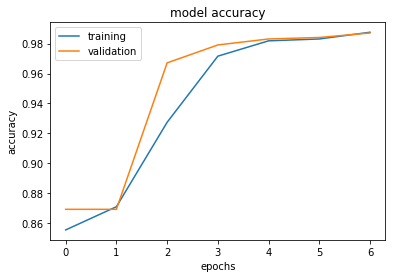

<Figure size 1440x720 with 0 Axes>

In [17]:
# summarize accuracy by epoch
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['training', 'validation'], loc='upper left')
plt.figure(figsize=(20,10))
plt.show()

Get examples from embeddings

In [18]:
from keras import backend as K

get_activations = K.function([model.layers[0].input, K.learning_phase()], [model.layers[0].output,])
activations = get_activations([trainFeatures,0])[0]

In [19]:
pd.set_option('display.max_colwidth', -1)
pd.DataFrame(train_texts).iloc[[113]]

,Text
2758,Yo we are watching a movie on netflix


In [20]:
trainFeatures[113]

array([ 309,   38,   22,  350,    4,  552,   19, 3691,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0])

In [21]:
df1 = pd.DataFrame(activations[113])

In [22]:
df1

,0,1,2,3,4,5,6,7,8,9
0,-0.006445,0.053770,0.043996,0.001513,0.030903,0.005937,-0.059703,-0.075510,-0.012467,0.028569
1,0.006317,0.028329,0.026945,-0.008623,0.061000,0.033060,0.000232,0.019226,-0.026690,-0.006966
2,0.092436,0.071748,0.047076,0.051690,0.000722,0.017235,-0.028312,-0.028541,-0.024147,0.095749
3,0.132012,0.095541,0.082435,-0.039043,0.054603,-0.079301,-0.126485,-0.128663,0.030744,0.058970
4,-0.012164,-0.065566,0.031306,-0.045708,-0.028781,-0.031413,-0.033747,0.102661,-0.016219,-0.031906
5,0.036690,0.045270,-0.026841,-0.105856,0.092024,-0.120458,-0.092930,0.005309,0.133586,0.032717
6,-0.029613,0.007504,0.021186,-0.050232,0.046458,-0.010115,-0.000169,-0.035338,-0.005546,0.019186
7,-0.024314,0.042671,-0.003475,-0.035902,0.043274,-0.047120,-0.032321,-0.027609,0.034321,0.033411
8,0.085031,0.082097,-0.045319,-0.007801,0.046190,-0.052575,-0.009507,-0.085788,0.007440,0.087125
9,0.085031,0.082097,-0.045319,-0.007801,0.046190,-0.052575,-0.009507,-0.085788,0.007440,0.087125


# Evaluate in test set

In [23]:
# Predict binary and probabilities
predictions_df = pd.DataFrame(model.predict(testFeatures))
predictions_binary_df = round(predictions_df)
accuracy_score(testLabels, predictions_binary_df)

0.9838709677419355

In [24]:
predictions_binary_df[0].value_counts(dropna=False)

0.0    482
1.0    76 
Name: 0, dtype: int64

# Save model architecture and pre-trained weights for Flask

In [25]:
# save to the directory with flask app
current_dir = os.getcwd()
output_dir = re.sub('Model and data', 'Flask application', current_dir)
os.chdir(output_dir)

In [26]:
# save tokenizer for preprocessing
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [27]:
# serialize model to JSON for Flask App
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [28]:
# serialize weights to HDF5
model.save_weights("model.h5")